**Imports and Settings**

In [1]:
# basic modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score 
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier

#settings
warnings.filterwarnings('ignore')
rs = 42
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
c = StratifiedKFold(n_splits=3)

# Dictionary for overview
models = {}

In [2]:
# Dataframe with engineered features (for further information notebook 06_Feature_engineering)
df = pd.read_csv('./data/mimic_premodel_advanced.csv')

In [3]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,tracheo,PaO2,base_excess,creatinin,hb,...,median_SaO2,std_SaO2,skew_SaO2,kurto_SaO2,minimum_leuko,maximum_leuko,median_leuko,std_leuko,skew_leuko,kurto_leuko
0,1.0,100017.0,258320.0,28.0,8.0,0.0,171.0,4.0,0.8,14.3,...,100.0,0.000000,0.000000,0.000000,9.3,9.3,9.30,1.284338,0.282498,0.424949
1,1.0,100035.0,245719.0,37.0,26.0,0.0,39.0,10.0,1.1,14.0,...,96.0,1.778516,0.104363,-0.201570,17.2,17.2,17.20,1.284338,0.282498,0.424949
2,1.0,100063.0,241782.0,46.0,11.0,0.0,365.0,2.0,1.0,14.0,...,100.0,0.421637,-1.778781,1.406250,8.4,8.4,8.40,1.284338,0.282498,0.424949
3,1.0,100087.0,294404.0,57.0,18.0,0.0,143.0,5.0,0.7,15.2,...,97.0,1.262354,0.717665,0.180998,8.5,8.7,8.60,0.141421,0.282498,0.424949
4,1.0,100141.0,243747.0,40.0,10.0,0.0,62.0,6.0,0.8,7.6,...,95.0,1.414791,0.514331,1.590646,4.9,5.8,5.35,0.636396,0.282498,0.424949


# Train/Test-Split and  Scaling 

We don't use the IDs (hadm_id, icustay_id) for the training.

In [4]:
X = df.iloc[:, 3:]
y = df.label

In [5]:
X.head()

,age,numb_diagn,tracheo,PaO2,base_excess,creatinin,hb,pH,FiO2,PEEP,...,median_SaO2,std_SaO2,skew_SaO2,kurto_SaO2,minimum_leuko,maximum_leuko,median_leuko,std_leuko,skew_leuko,kurto_leuko
0,28.0,8.0,0.0,171.0,4.0,0.8,14.3,7.52,40.000001,5.0,...,100.0,0.000000,0.000000,0.000000,9.3,9.3,9.30,1.284338,0.282498,0.424949
1,37.0,26.0,0.0,39.0,10.0,1.1,14.0,7.41,70.000000,5.0,...,96.0,1.778516,0.104363,-0.201570,17.2,17.2,17.20,1.284338,0.282498,0.424949
2,46.0,11.0,0.0,365.0,2.0,1.0,14.0,7.39,50.000000,0.0,...,100.0,0.421637,-1.778781,1.406250,8.4,8.4,8.40,1.284338,0.282498,0.424949
3,57.0,18.0,0.0,143.0,5.0,0.7,15.2,7.47,30.000000,5.0,...,97.0,1.262354,0.717665,0.180998,8.5,8.7,8.60,0.141421,0.282498,0.424949
4,40.0,10.0,0.0,62.0,6.0,0.8,7.6,7.48,50.000000,2.0,...,95.0,1.414791,0.514331,1.590646,4.9,5.8,5.35,0.636396,0.282498,0.424949


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4068 samples.
Testing set has 1357 samples.


In [7]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Function

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Now we train different classifiers, initially with preset hyperparameters. Then the hyperparameters are optimized in each case.

# Logistic Regression

## Hyperparameter by default

In [9]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [10]:
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.67      0.30      0.41       442
         1.0       0.73      0.93      0.82       915

    accuracy                           0.72      1357
   macro avg       0.70      0.61      0.62      1357
weighted avg       0.71      0.72      0.69      1357

F-Beta-Score(0.5) =  0.77


Confusion matrix, without normalization
[[133 309]
 [ 66 849]]


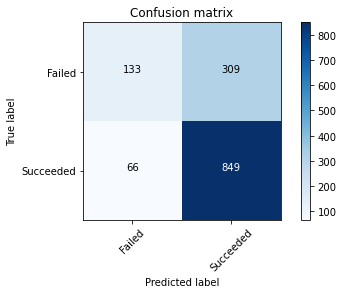

In [11]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

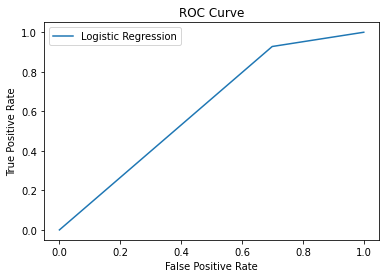

AUC(logReg)= 0.71


In [12]:
# Plot the ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_prob = lr.predict_proba(X_test)
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")

In [13]:
models['logReg_simple'] = [precision_score(y_test, y_pred_lr),
                    fbeta_score(y_test, y_pred_lr, beta=0.5),
                    roc_auc_score(y_test, y_pred_lr_prob[:,1]),
                    accuracy_score(y_test, y_pred_lr)]

## Hyperparameter tuning

**First we search for the appropriate range in a random selection of the hyperparameters. The F-Beta Score with Beta = 0.5  is used as the scorer.**

In [14]:
# Hyperparameter grid for RandomSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [100, 10, 1, 0.1, 0.01] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = fhalf_scorer, cv = c, 
                        n_iter = 100, verbose = 1, random_state=rs)

# Fit 
lr_rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.1s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=1)

In [15]:
lr_rs.best_params_

{'penalty': 'l2', 'C': 0.1}

**Now, in the area of the best hyperparameters, a more precise search is being made for the best model.**

In [16]:
# Hyperparameter grid for GridSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [3, 2, 1 , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_gs = GridSearchCV(estimator, param_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
lr_gs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 177 out of 192 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    1.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2,
                               0.1, 0.09, 0.08, 0.07, 0.06],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [17]:
lr_gs.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [18]:
best_model_lr_gs = lr_gs.best_estimator_

**Evaluate the best model.**

In [19]:
y_pred_lr_best = best_model_lr_gs.predict(X_test)
print(classification_report(y_test, y_pred_lr_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.68      0.29      0.41       442
         1.0       0.73      0.93      0.82       915

    accuracy                           0.73      1357
   macro avg       0.71      0.61      0.62      1357
weighted avg       0.72      0.73      0.69      1357

F-Beta-Score(0.5) =  0.77


Confusion matrix, without normalization
[[130 312]
 [ 60 855]]


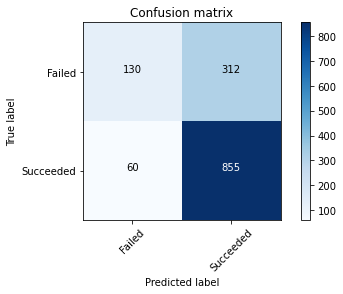

In [20]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

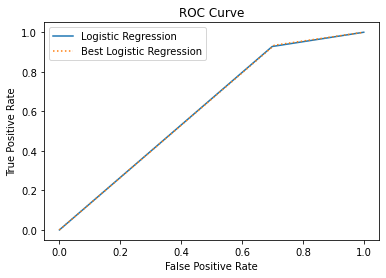

AUC(logReg)= 0.71
AUC(BestlogReg)= 0.71


In [21]:
# Plot the ROC curve
fpr_lr_best, tpr_lr_best, thresholds_lr_best = roc_curve(y_test, y_pred_lr_best)
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.plot(fpr_lr_best, tpr_lr_best, linestyle=':', label='Best Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_best_prob = best_model_lr_gs.predict_proba(X_test)
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")
print(f"AUC(BestlogReg)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}")

In [22]:
models['logReg_best'] = [precision_score(y_test, y_pred_lr_best),
                    fbeta_score(y_test, y_pred_lr_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_lr_best_prob[:,1]),
                    accuracy_score(y_test, y_pred_lr_best)]

# Random Forest

##  Simple Model

In [23]:
rf_clf_base = RandomForestClassifier(random_state=rs)
rf_clf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
y_pred_rf_clf_base = rf_clf_base.predict(X_test)

### Evaluate Simple Model

In [25]:
print(classification_report(y_test, y_pred_rf_clf_base))
print(confusion_matrix(y_test, y_pred_rf_clf_base))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.75      0.32      0.45       442
         1.0       0.74      0.95      0.83       915

    accuracy                           0.75      1357
   macro avg       0.75      0.64      0.64      1357
weighted avg       0.75      0.75      0.71      1357

[[143 299]
 [ 47 868]]
F-Beta-Score(0.5) =  0.78


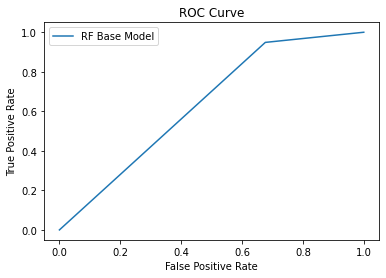

AUC(BaseModel)= 0.71


In [26]:
# ROC Curve Base Model and Dummy
fpr_rf_bm, tpr_rf_bm, thresholds_rf_bm = roc_curve(y_test, y_pred_rf_clf_base)
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_clf_base = rf_clf_base.predict_proba(X_test)
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")

In [27]:
models['RF_simple'] = [precision_score(y_test, y_pred_rf_clf_base),
                    fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5),
                    roc_auc_score(y_test, y_proba_rf_clf_base[:,1]),
                    accuracy_score(y_test, y_pred_rf_clf_base)]

In [28]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_clf_base.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## Random Search

In [29]:
# Set scorer for random search to f-beta 0.5
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
# set cross-validation to a stratified split of 3
c_strat=StratifiedKFold(n_splits=3)

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [31]:
# Random search of parameters, using 3 fold cross validation 
rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, scoring=fhalf_scorer, 
                               n_iter = 100, cv = c_strat, random_state=rs, n_jobs = -1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5))

In [32]:
rf_random.best_params_

{'n_estimators': 311,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

## Grid Search

In [33]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [20, 30, 40],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [500, 1000, 1500]
}

In [34]:
# Instantiate the grid search model
grid_search_rf_adv = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, scoring=fhalf_scorer, 
                           cv = c_strat, n_jobs = -1)

# Fit the grid search to the data
grid_search_rf_adv.fit(X_train, y_train)

# Y Predict
y_pred_rf_adv = grid_search_rf_adv.predict(X_test)

In [35]:
grid_search_rf_adv.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 500}

In [36]:
best_model_rf_adv = grid_search_rf_adv.best_estimator_

### Evaluate Grid Search

In [37]:
print(classification_report(y_test, y_pred_rf_adv))
print(confusion_matrix(y_test, y_pred_rf_adv))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_adv, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.77      0.30      0.44       442
         1.0       0.74      0.96      0.83       915

    accuracy                           0.74      1357
   macro avg       0.76      0.63      0.64      1357
weighted avg       0.75      0.74      0.70      1357

[[134 308]
 [ 39 876]]
F-Beta-Score(0.5) =  0.78


Confusion matrix, without normalization
[[134 308]
 [ 39 876]]


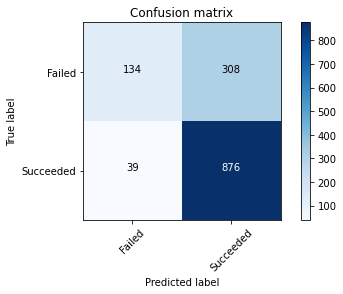

In [38]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rf_adv)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

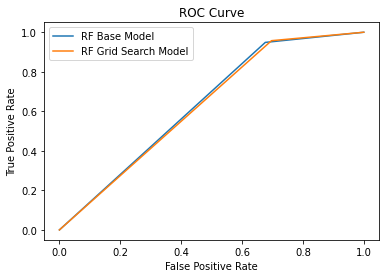

AUC(BaseModel)= 0.71
AUC(GridSearch)= 0.72


In [39]:
# ROC Curve Random Search Model, Base Model and Dummy
fpr_rf_gs, tpr_rf_gs, thresholds_rf_gs = roc_curve(y_test, y_pred_rf_adv)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.plot(fpr_rf_gs, tpr_rf_gs, linestyle='-', label='RF Grid Search Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_adv = best_model_rf_adv.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")
print(f"AUC(GridSearch)= {roc_auc_score(y_test, y_proba_rf_adv[:,1]):.2f}")

In [40]:
models['RF_best'] = [precision_score(y_test, y_pred_rf_adv),
                    fbeta_score(y_test, y_pred_rf_adv, beta=0.5),
                    roc_auc_score(y_test, y_proba_rf_adv[:,1]),
                    accuracy_score(y_test, y_pred_rf_adv)]

# AdaBoost

**First a model with Hyperparamters by Default**

In [41]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

         0.0       0.69      0.38      0.49       442
         1.0       0.75      0.92      0.83       915

    accuracy                           0.74      1357
   macro avg       0.72      0.65      0.66      1357
weighted avg       0.73      0.74      0.72      1357



In [42]:
fbeta_score(y_test, y_pred_ada, beta=0.5)

0.7804651162790699

Text(0.5, 1.0, 'Confusion matrix')

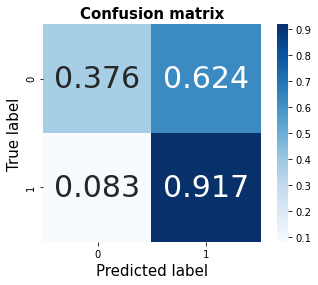

In [43]:
cm = confusion_matrix(y_test, ada.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

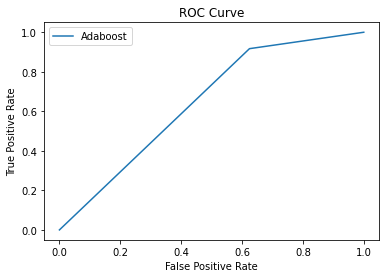

AUC(Adaboost)= 0.72


In [44]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

In [45]:
models['Ada_simple'] = [precision_score(y_test, y_pred_ada),
                    fbeta_score(y_test, y_pred_ada, beta=0.5),
                    roc_auc_score(y_test, y_pred_ada_prob[:,1]),
                    accuracy_score(y_test, y_pred_ada)]

## Randomsearch

In [46]:
ada_grid = dict()
ada_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
ada_grid['n_estimators'] = [100, 200, 250, 300, 500]

model = AdaBoostClassifier()
grid = ada_grid
    
# run randomized search and optimize for fhalf_scorer
ada_rdm = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs, cv=c)
search = ada_rdm.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.3min finished


In [47]:
print(search.best_params_)

{'n_estimators': 200, 'learning_rate': 0.1}


In [48]:
y_pred_ada_rdm = ada_rdm.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred_ada_rdm))

              precision    recall  f1-score   support

         0.0       0.76      0.33      0.46       442
         1.0       0.75      0.95      0.84       915

    accuracy                           0.75      1357
   macro avg       0.75      0.64      0.65      1357
weighted avg       0.75      0.75      0.71      1357



In [50]:
fbeta_score(y_test, y_pred_ada_rdm, beta=0.5)

0.7788134074206847

Text(0.5, 1.0, 'Confusion matrix')

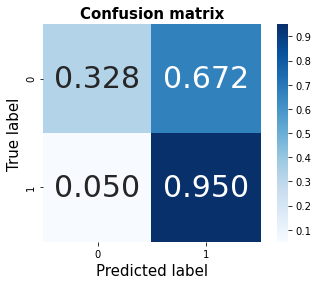

In [51]:
cm = confusion_matrix(y_test, ada_rdm.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

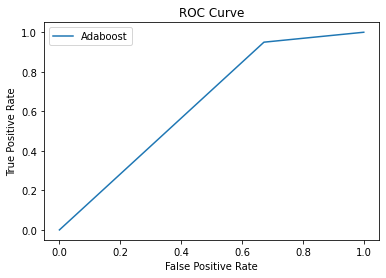

AUC(Adaboost)= 0.73


In [52]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada_rdm)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_rdm.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

## Gridsearch

In [53]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# TODO: Initialize the classifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[200],                
              'learning_rate':[0.1, 0.08, 0.12,],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = fhalf_scorer

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(ada, parameters,scorer, cv=c) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_ada = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (ada.fit(X_train, y_train)).predict(X_test)
best_predictions = best_ada.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_ada)


Unoptimized model
------
Accuracy score on testing data: 0.6315
F-score on testing data: 0.7273

Optimized Model
------
Final accuracy score on the testing data: 0.7421
Final F-score on the testing data: 0.7749
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.08, n_estimators=200)


In [54]:
ada_grid = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=250)
ada_grid.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=250)

In [55]:
y_pred_ada_grid = ada_grid.predict(X_test)

In [56]:
print(classification_report(y_test, y_pred_ada_grid))

              precision    recall  f1-score   support

         0.0       0.71      0.35      0.47       442
         1.0       0.75      0.93      0.83       915

    accuracy                           0.74      1357
   macro avg       0.73      0.64      0.65      1357
weighted avg       0.74      0.74      0.71      1357



In [57]:
fbeta_score(y_test, y_pred_ada_grid, beta=0.5)

0.7782030253326043

Text(0.5, 1.0, 'Confusion matrix')

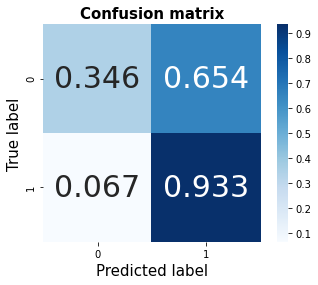

In [58]:
cm = confusion_matrix(y_test, ada_grid.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

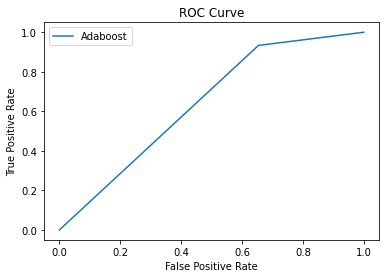

AUC(Adaboost)= 0.70


In [59]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada_grid)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_grid.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

In [60]:
models['Ada_best'] = [precision_score(y_test, y_pred_ada_grid),
                    fbeta_score(y_test, y_pred_ada_grid, beta=0.5),
                    roc_auc_score(y_test, y_pred_ada_prob[:,1]),
                    accuracy_score(y_test, y_pred_ada_grid)]

# XGBoost

**First a model with Hyperparamters by Default**

In [61]:
# instanciate classifier, fit model
xgboost = XGBClassifier(random_state=rs)
xgboost.fit(X_train, y_train)

XGBClassifier(random_state=42)

In [62]:
y_pred_xgb = xgboost.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.76      0.35      0.48       442
         1.0       0.75      0.95      0.84       915

    accuracy                           0.75      1357
   macro avg       0.76      0.65      0.66      1357
weighted avg       0.75      0.75      0.72      1357



In [64]:
fbeta_score(y_test, y_pred_xgb, beta=0.5)

0.7831978319783198

Text(0.5, 1.0, 'Confusion matrix')

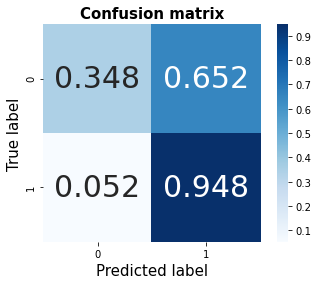

In [65]:
cm = confusion_matrix(y_test, xgboost.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

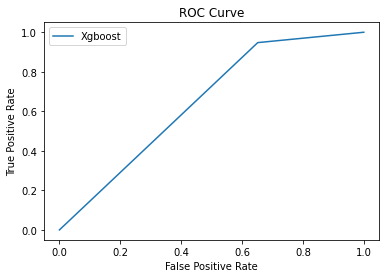

AUC(Xgboost)= 0.74


In [66]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = xgboost.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

In [67]:
models['XGB_simple'] = [precision_score(y_test, y_pred_xgb),
                    fbeta_score(y_test, y_pred_xgb, beta=0.5),
                    roc_auc_score(y_test, y_pred_xgb_prob[:,1]),
                    accuracy_score(y_test, y_pred_xgb)]

## random search

In [68]:
xgb_grid = dict()
xgb_grid['max_depth'] = [2, 3, 4, 5, 6]
xgb_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
xgb_grid['gamma'] = [0,0.1,0.2,0.3,0.4,0.5]

model = XGBClassifier()
grid = xgb_grid
    
# run randomized search and optimize for fhalf_scorer
clf = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs,cv=c)
search = clf.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   41.5s finished


In [69]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.74      0.33      0.46       442
         1.0       0.74      0.95      0.83       915

    accuracy                           0.74      1357
   macro avg       0.74      0.64      0.64      1357
weighted avg       0.74      0.74      0.71      1357



In [70]:
print(search.best_params_)

{'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}


best result: {'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}

In [71]:
y_pred_xgb_rdm = clf.predict(X_test)

In [72]:
fbeta_score(y_test, y_pred_xgb_rdm, beta=0.5)

0.7774582060039547

Text(0.5, 1.0, 'Confusion matrix')

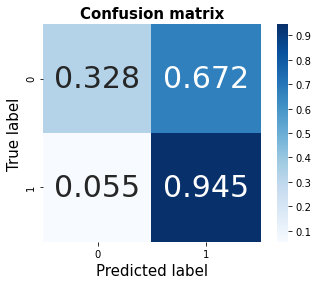

In [73]:
cm = confusion_matrix(y_test, clf.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

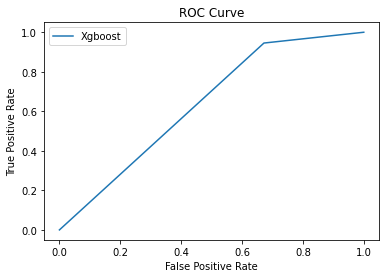

AUC(Xgboost)= 0.71


In [74]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_lr = roc_curve(y_test, y_pred_xgb_rdm)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = clf.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

## Gridsearch

In [75]:
param_grid = {
    'max_depth': [2,3,4],
    'learning_rate': [0.02, 0.01],
    'gamma': [0.3, 0.35, 0.25],}

optimal_params = GridSearchCV(
    estimator= XGBClassifier(), cv=c,
    param_grid=param_grid,
     scoring = fhalf_scorer)## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 3}


In [76]:
y_pred_xgb_grid = optimal_params.predict(X_test)

In [77]:
print(classification_report(y_test, y_pred_xgb_grid))

              precision    recall  f1-score   support

         0.0       0.74      0.33      0.46       442
         1.0       0.74      0.95      0.83       915

    accuracy                           0.74      1357
   macro avg       0.74      0.64      0.64      1357
weighted avg       0.74      0.74      0.71      1357



In [78]:
fbeta_score(y_test, y_pred_xgb_grid, beta=0.5)

0.7774582060039547

Text(0.5, 1.0, 'Confusion matrix')

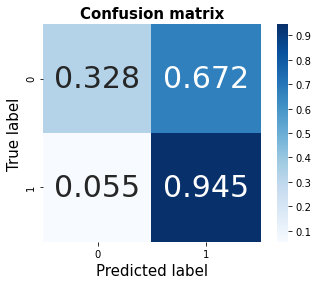

In [79]:
cm = confusion_matrix(y_test, optimal_params.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

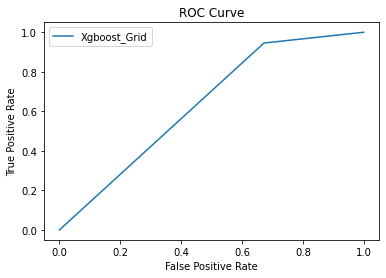

AUC(Xgboost)= 0.71


In [80]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_grid)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost_Grid')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = optimal_params.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

In [81]:
models['XGB_best'] = [precision_score(y_test, y_pred_xgb_grid),
                    fbeta_score(y_test, y_pred_xgb_grid, beta=0.5),
                    roc_auc_score(y_test, y_pred_xgb_prob[:,1]),
                    accuracy_score(y_test, y_pred_xgb_grid)]

# SVM Classifier

## Simple Model

In [82]:
svc_model = SVC(C=1, kernel='rbf', probability=True, random_state=rs)
svc = svc_model.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred_svc))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.73      0.28      0.41       442
         1.0       0.73      0.95      0.83       915

    accuracy                           0.73      1357
   macro avg       0.73      0.62      0.62      1357
weighted avg       0.73      0.73      0.69      1357

F-Beta-Score(0.5) =  0.77


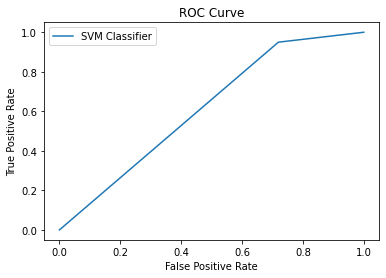

AUC (SVC)= 0.71


In [84]:
# Plot the ROC curve
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_svc)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_svc, tpr_svc, linestyle='-', label='SVM Classifier') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_svc_prob = svc.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC (SVC)= {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}")

In [85]:
models['SVC_simple'] = [precision_score(y_test, y_pred_svc),
                    fbeta_score(y_test, y_pred_svc, beta=0.5),
                    roc_auc_score(y_test, y_pred_svc_prob[:,1]),
                    accuracy_score(y_test, y_pred_svc)]

## Tuning with Gridsearch

In [86]:
grid_svc = {'C': [0.1,1, 10, 50, 100],
             #'kernel': ['linear', 'rbf', 'poly','sigmoid'],
             'kernel': ['linear', 'rbf'],
             'gamma' : [1, 0.1, 0.01, 0.001]
             }

In [87]:
svc_grid = GridSearchCV(estimator= SVC(), 
                        param_grid=grid_svc, 
                        cv=c, 
                        verbose=2, n_jobs=-1,
                        scoring=fhalf_scorer)

In [88]:
svc_grid.fit(X_train, y_train)
y_pred_svc_grid = svc_grid.predict(X_test)
svc_grid.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 209.9min finished


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [89]:
svc_bestmodel = SVC(C=100, kernel='rbf', probability=True, gamma=0.001, random_state=rs)
svc_best = svc_bestmodel.fit(X_train, y_train)
y_pred_svc_best = svc_best.predict(X_test)

In [90]:
print(classification_report(y_test, y_pred_svc_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.68      0.34      0.45       442
         1.0       0.74      0.92      0.82       915

    accuracy                           0.73      1357
   macro avg       0.71      0.63      0.64      1357
weighted avg       0.72      0.73      0.70      1357

F-Beta-Score(0.5) =  0.77


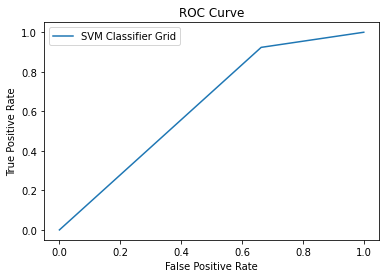

AUC (SVC)= 0.71
AUC (SVC_best)= 0.70


In [91]:
# Plot the ROC curve
fpr_svc_grid, tpr_svc_grid, thresholds_svc_grid = roc_curve(y_test, y_pred_svc_best)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_svc_grid, tpr_svc_grid, linestyle='-', label='SVM Classifier Grid') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_svc_prob_best = svc_best.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC (SVC)= {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}")
print(f"AUC (SVC_best)= {roc_auc_score(y_test, y_pred_svc_prob_best[:,1]):.2f}")

In [92]:
models['SVC_grid'] = [precision_score(y_test, y_pred_svc_best),
                    fbeta_score(y_test, y_pred_svc_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_svc_prob_best[:,1]),
                    accuracy_score(y_test, y_pred_svc_best)]

# kNN

## Simple kNN

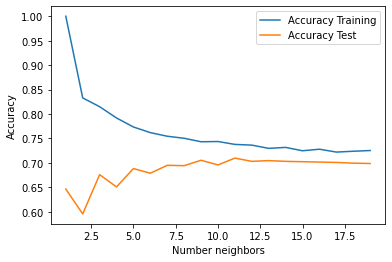

In [93]:
train_accuracy = []
test_accuracy = []
train_beta = []
test_beta = []

# Probiere Werte für k von 1 bis 10 aus
neighbor_settings = range(1, 20)

for k in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_beta.append(fbeta_score(y_test, y_pred, beta=0.5))
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbor_settings, train_accuracy, label='Accuracy Training')
plt.plot(neighbor_settings, test_accuracy, label='Accuracy Test')
plt.ylabel('Accuracy')
plt.xlabel('Number neighbors')
plt.legend();

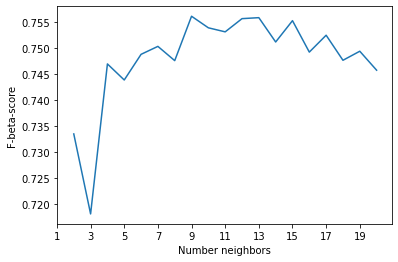

In [94]:
plt.plot(neighbor_settings, train_beta)
plt.ylabel('F-beta-score')
plt.xlabel('Number neighbors')
plt.xticks(ticks=list(range(0,20,2)) ,labels=list(range(1,20,2)));

We take 12 neighbours as best value, for the first simple model.

In [95]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)
y_pred_knn= knn.predict(X_test)

In [96]:
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_knn, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.58      0.31      0.40       442
         1.0       0.73      0.89      0.80       915

    accuracy                           0.70      1357
   macro avg       0.66      0.60      0.60      1357
weighted avg       0.68      0.70      0.67      1357

[[136 306]
 [ 97 818]]
F-Beta-Score(0.5) =  0.76


In [97]:
y_pred_knn_prob = clf.predict_proba(X_test)


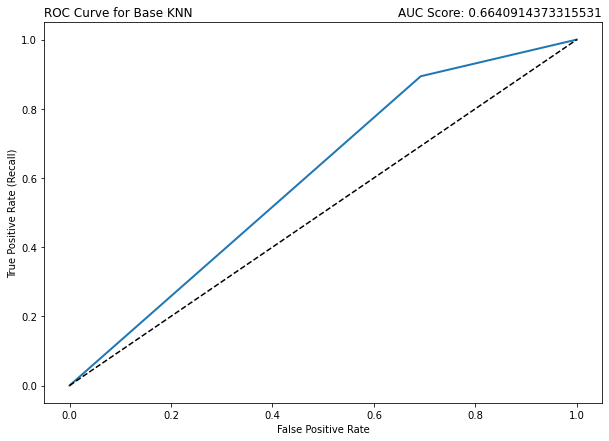

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
auc_score = roc_auc_score(y_test, y_pred_knn_prob[:,1])

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Base KNN', loc='left')
plt.title(f'AUC Score: {auc_score}', loc='right');

In [99]:
models['knn_simple'] = [precision_score(y_test, y_pred_knn),
                    fbeta_score(y_test, y_pred_knn, beta=0.5),
                    roc_auc_score(y_test, y_pred_knn_prob[:,1]),
                    accuracy_score(y_test, y_pred_knn)]

## Optimize Model

In [100]:
grid_knn = {'n_neighbors' : list(range(1,30)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,20)),
             'metric' : ['euclidean','minkowski','manhattan']}

In [101]:
knn_grid_mod = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid_knn, 
                        cv=c, 
                        verbose=False, n_jobs=-1,
                        scoring=fhalf_scorer)
knn_grid_mod.fit(X_train, y_train)
y_pred = knn_grid_mod.predict(X_test)


In [102]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.59      0.30      0.40       442
         1.0       0.73      0.90      0.80       915

    accuracy                           0.70      1357
   macro avg       0.66      0.60      0.60      1357
weighted avg       0.68      0.70      0.67      1357

[[133 309]
 [ 94 821]]
F-Beta-Score(0.5) =  0.76


In [103]:
knn_grid_mod.best_params_

{'leaf_size': 1,
 'metric': 'euclidean',
 'n_neighbors': 14,
 'weights': 'uniform'}

In [104]:
y_pred_prob = knn_grid_mod.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}')

ROC-AUC-Score = 0.66


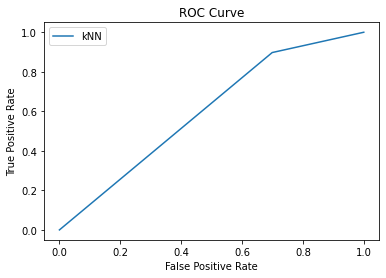

AUC(kNN)= 0.66


In [105]:
# Plot the ROC curve
fpr_knn_grid, tpr_knn_grid, thresholds_grid= roc_curve(y_test, y_pred)
plt.plot(fpr_knn_grid, tpr_knn_grid, linestyle='-', label='kNN') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_prob =knn_grid_mod.predict_proba(X_test)
print(f"AUC(kNN)= {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}")

Confusion matrix, without normalization
[[133 309]
 [ 94 821]]


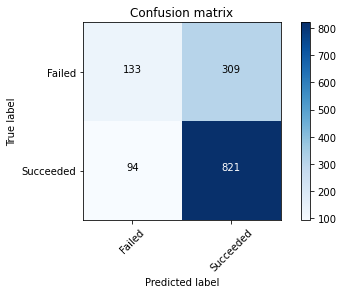

In [106]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [107]:
models['knn_best'] = [precision_score(y_test, y_pred),
                    fbeta_score(y_test, y_pred, beta=0.5),
                    roc_auc_score(y_test, y_pred_prob[:,1]),
                    accuracy_score(y_test, y_pred)]

# Naive Bayes

## Hyperparameter by default

In [108]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

In [109]:
print(classification_report(y_test, y_pred_gnb))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.41      0.70      0.52       442
         1.0       0.78      0.52      0.62       915

    accuracy                           0.58      1357
   macro avg       0.60      0.61      0.57      1357
weighted avg       0.66      0.58      0.59      1357

F-Beta-Score(0.5) =  0.71


Confusion matrix, without normalization
[[309 133]
 [439 476]]


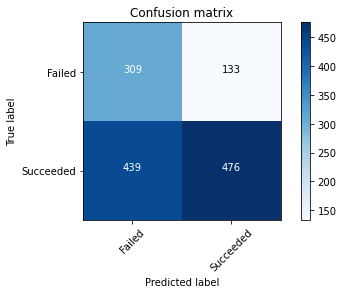

In [110]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

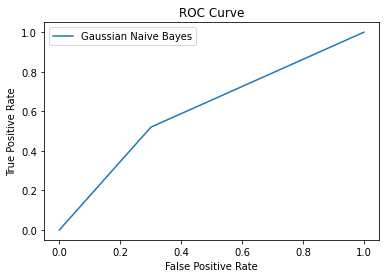

AUC(GNB)= 0.66


In [111]:
# Plot the ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_gnb)
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Gaussian Naive Bayes') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_prob = gnb.predict_proba(X_test)
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")

In [112]:
models['GNB_simple'] = [precision_score(y_test, y_pred_gnb),
                    fbeta_score(y_test, y_pred_gnb, beta=0.5),
                    roc_auc_score(y_test, y_pred_gnb_prob[:,1]),
                    accuracy_score(y_test, y_pred_gnb)]

## Hyperparameter tuning

In [113]:
# Hyperparameter grid for GridSearch for Naive Bayes
params_grid = {'var_smoothing': np.logspace(1,-9, num=1000)}

# Estimator for use in gridSearch
estimator = GaussianNB()

# Create the gridSearch model
gnb_gs = GridSearchCV(estimator, params_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
gnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    6.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+01, 9.77214697e+00, 9.54948564e+00, 9.33189772e+00,
       9.11926760e+00, 8.91148232e+00, 8.70843150e+00, 8.51000725e+00,
       8.31610415e+00, 8.12661920e+00, 7.94145172e+00, 7.76050334e+00,
       7.58367791e+00, 7.41088152e...
       1.54949504e-09, 1.51418933e-09, 1.47968806e-09, 1.44597292e-09,
       1.41302599e-09, 1.38082977e-09, 1.34936714e-09, 1.31862140e-09,
       1.28857621e-09, 1.25921561e-09, 1.23052400e-09, 1.20248614e-09,
       1.17508713e-09, 1.14831241e-09, 1.12214777e-09, 1.09657929e-09,
       1.07159340e-09, 1.04717682e-09, 1.02331658e-09, 1.00000000e-09])},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [114]:
gnb_gs.best_params_

{'var_smoothing': 1.5459277364194774}

In [115]:
best_model_gnb_gs = gnb_gs.best_estimator_

In [116]:
y_pred_gnb_best = best_model_gnb_gs.predict(X_test)
print(classification_report(y_test, y_pred_gnb_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.69      0.22      0.34       442
         1.0       0.72      0.95      0.82       915

    accuracy                           0.71      1357
   macro avg       0.70      0.59      0.58      1357
weighted avg       0.71      0.71      0.66      1357

F-Beta-Score(0.5) =  0.75


Confusion matrix, without normalization
[[ 99 343]
 [ 44 871]]


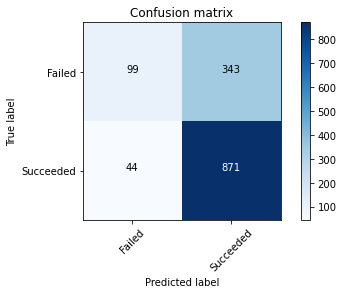

In [117]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

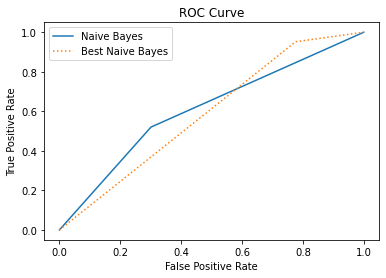

AUC(GNB)= 0.66
AUC(BestGNB)= 0.68


In [118]:
# Plot the ROC curve
fpr_gnb_best, tpr_gnb_best, thresholds_gnb_best = roc_curve(y_test, y_pred_gnb_best)
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Naive Bayes') 
plt.plot(fpr_gnb_best, tpr_gnb_best, linestyle=':', label='Best Naive Bayes')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_best_prob = best_model_gnb_gs.predict_proba(X_test)
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")
print(f"AUC(BestGNB)= {roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]):.2f}")

In [119]:
models['GNB_best'] = [precision_score(y_test, y_pred_gnb_best),
                    fbeta_score(y_test, y_pred_gnb_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]),
                    accuracy_score(y_test, y_pred_gnb_best)]

# Overview

**Comparison of the results**

In [120]:
overview = pd.DataFrame.from_dict(models, orient='index')
overview.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
overview.sort_values(by='F-Beta(0.5)', ascending = False)

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
XGB_simple,0.750649,0.783198,0.736580,0.752395
Ada_simple,0.752466,0.780465,0.719976,0.740604
Ada_best,0.747157,0.778203,0.698017,0.742078
XGB_best,0.744406,0.777458,0.709308,0.744289
RF_simple,0.743787,0.777360,0.709343,0.745026
RF_best,0.739865,0.775084,0.717486,0.744289
SVC_grid,0.742531,0.772819,0.699533,0.732498
SVC_simple,0.732098,0.767261,0.707983,0.731761
logReg_best,0.732648,0.765717,0.710766,0.725866
logReg_simple,0.733161,0.765279,0.708451,0.723655


It appears that for Adaboost, XGBoost, RF and knn the grid search parameters have not led to an improvement of the base model performance.

In [121]:
bestmodels = overview.drop(['logReg_simple', 'RF_simple', 'Ada_simple', 'XGB_simple',
                            'SVC_simple', 'knn_simple', 'GNB_simple'],axis=0)

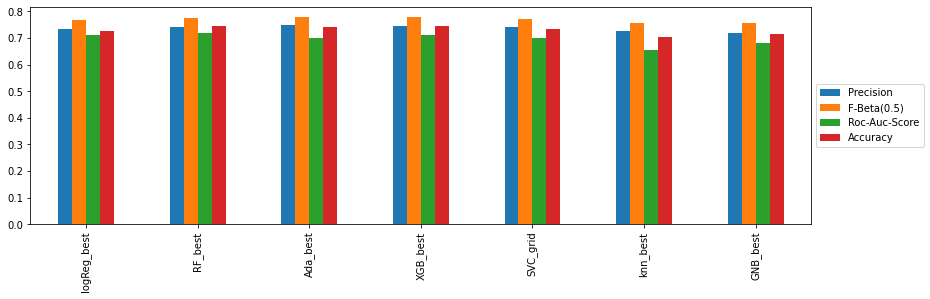

In [122]:
bestmodels.plot(kind='bar', figsize=(14,4))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

**XGBoost and AdaBoost show the best performance with regard to all evaluation metrics.**  

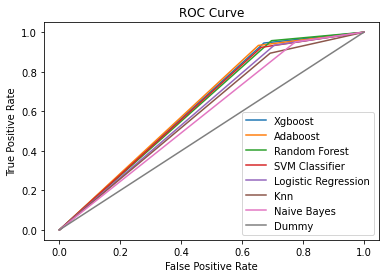

AUC(Xgboost)= 0.71
AUC(Adaboost)= 0.70
AUC(Random Forest)= 0.72
AUC (SVM Classifier)= 0.70
AUC(Logistic Regression)= 0.71
AUC(Knn)= 0.66
AUC(Naive Bayes)= 0.68
AUC(Dummy)= 0.49


In [123]:
# Plot the ROC curve
plt.plot(fpr_xgb, tpr_xgb, label='Xgboost')
plt.plot(fpr_ada, tpr_ada, label='Adaboost')
plt.plot(fpr_rf_gs, tpr_rf_gs, label='Random Forest')
plt.plot(fpr_svc_grid, tpr_svc_grid, label='SVM Classifier')
plt.plot(fpr_lr_best, tpr_lr_best, label='Logistic Regression')
plt.plot(fpr, tpr, label='Knn')
plt.plot(fpr_gnb_best, tpr_gnb_best, label='Naive Bayes')
plt.plot([0, 1], [0, 1], label = 'Dummy') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")
print(f"AUC(Random Forest)= {roc_auc_score(y_test, y_proba_rf_adv[:,1]):.2f}")
print(f"AUC(SVM Classifier)= {roc_auc_score(y_test, y_pred_svc_prob_best[:,1]):.2f}")
print(f"AUC(Logistic Regression)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}")
print(f"AUC(Knn)= {roc_auc_score(y_test, y_pred_knn_prob[:,1]):.2f}")
print(f"AUC(Naive Bayes)= {roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]):.2f}")
print("AUC(Dummy)= 0.49")

ROC curve of selected high performing machine learning models.
The Random Forest model performs relatively better than other ones.

# Feature Importance

##### Set the color palette

In [124]:
# Explore color codes
blue_1 = '#4fbbd2'
blue_2 = '#0085a0'
blue_3 = '#173f6d'
green = '#21a8a4'
red = '#f27050'
orange = '#ffa733'

# List of colors 
colors = [blue_3, blue_2, blue_1, green, orange, red]
current_palette = sns.color_palette(colors)

##### Prepare the KNN metric

In [125]:
from sklearn.inspection import permutation_importance
results_knn = permutation_importance(knn_grid_mod, X, y, scoring=fhalf_scorer)
importance = results_knn.importances_mean

##### Initialize our best fitted Classifiers 

In [126]:
ABC = ada.feature_importances_
XGBC = xgboost.feature_importances_
RDMC = best_model_rf_adv.feature_importances_
KNNC = abs(importance)
LOGC = abs(best_model_lr_gs.coef_[0])


# List of Tree-based Classifiers used for feature Selection
best_clf = [ABC, XGBC, RDMC, KNNC, LOGC]

# List of Classifier Names
name_clf = ["ABC", "XGBC", "RDMC", "KNNC", "LOGC"]

##### make a function that gives us only the first 25 best features

In [127]:
def feature_selection(results_dict, tree_clf, name_clf, n=25):
    
    # n is the number of Features + classifier added to the results dictionary (default=20)
    # and printed during process for each classifier
    # if n=None all Features + classifier are added and printed
    
    count = 0
    
    for classifier in tree_clf:
        
        indices = np.argsort(classifier)[::-1]
        feature_name = X.columns[indices]
    
        # Write first n Ranks to dictionary results_dict as 
        # "name_clf: (feature_name, importance)", default is n=20
        results_dict[name_clf[count]] = list(zip(feature_name[0:n], classifier[indices][0:n]))     
        
        count +=1
    
        
    return results_dict

##### Create dataframes for visualization

In [128]:
# Create Dictionary for Feature Selection Results
results_fs = {}

# Use feature_selection function 
feature_selection(results_fs, best_clf, name_clf)

# Making Dataframes from results_fs Dictionary
log_dataframe = pd.DataFrame(results_fs["LOGC"]).rename(columns={0:"Features", 1:"importance value"})
rfc_dataframe = pd.DataFrame(results_fs["RDMC"]).rename(columns={0:"Features", 1:"importance value"})
knn_dataframe = pd.DataFrame(results_fs["KNNC"]).rename(columns={0:"Features", 1:"importance value"})
abc_dataframe = pd.DataFrame(results_fs["ABC"]).rename(columns={0:"Features", 1:"importance value"})
xgbc_dataframe = pd.DataFrame(results_fs["XGBC"]).rename(columns={0:"Features", 1:"importance value"})

##### make the visualization

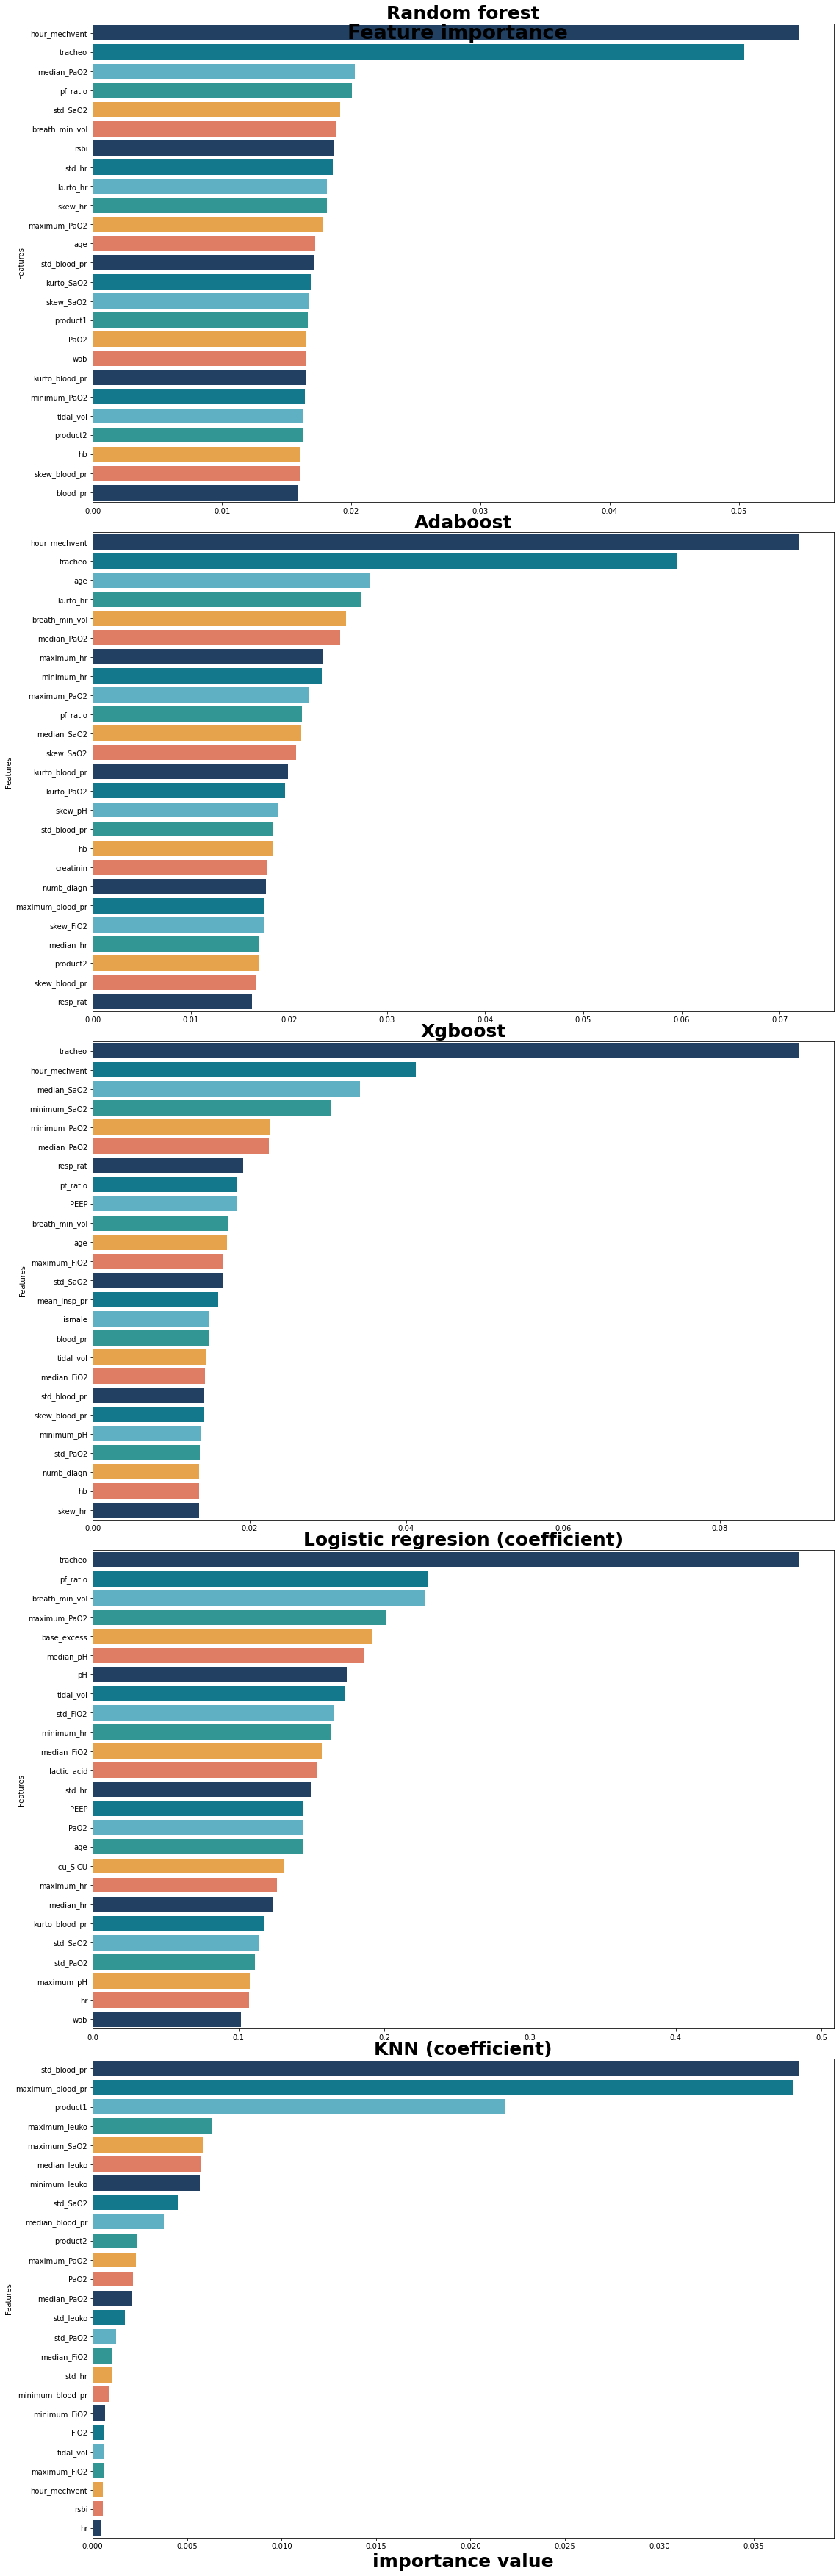

In [129]:
# Plots for feature Selection
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15, 49))
f.suptitle("Feature importance",fontsize=27, fontweight = 'bold', y= 0.98)
f.tight_layout(pad=2.0)
sns.set_context("poster")

sns.barplot(y="Features", x="importance value", data=rfc_dataframe, ax=ax1, palette=current_palette)
sns.barplot(y="Features", x="importance value", data=abc_dataframe, ax=ax2, palette=current_palette)
sns.barplot(y="Features", x="importance value", data=xgbc_dataframe, ax=ax3, palette=current_palette) 
sns.barplot(y="Features", x="importance value", data=log_dataframe, ax=ax4, palette=current_palette)
sns.barplot(y="Features", x="importance value", data=knn_dataframe, ax=ax5, palette=current_palette)

ax1.set_title("Random forest", fontsize=25, fontweight="bold")
ax2.set_title("Adaboost", fontsize=25, fontweight="bold")
ax3.set_title("Xgboost", fontsize=25, fontweight="bold")
ax4.set_title("Logistic regresion (coefficient)", fontsize=25, fontweight="bold")
ax5.set_title("KNN (coefficient)", fontsize=25, fontweight="bold")

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel("importance value", fontsize=25, fontweight="bold");

**With the exception of the kNN model, the features have a very similar order of importance in all models.** The tree-based models in particular are very similar in terms of feature importance.  
The most important features are:
+ tracheo  
+ hours_mechvent  
+ age  
+ Blood gas analysis   
+ Breathing parameters
 

# Best models with feature reduction

In order to check whether the reduction of the dimension improves the model or whether a lower number of features is sufficient, we now examine the performance of the model with a reduced number of features. For this we vary the number of features (according to the importance in the respective model) and evaluate the model.

In [130]:
def feature_redu (dataframe, number_features, estimator):
    liste = list(dataframe.Features.loc[:(number_features-1)].values)
    X1 = df[liste]
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.25, random_state=rs, stratify=y)
    scaler = preprocessing.StandardScaler().fit(X_train1)
    X_train1 = scaler.transform(X_train1)
    X_test1 = scaler.transform(X_test1)
    
    clf_reduced = estimator
    clf_reduced.fit(X_train1, y_train1)
    y_pred_clf_reduced = clf_reduced.predict(X_test1)
    #print(classification_report(y_test1, y_pred_clf_reduced))
    #print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test1, y_pred_clf_reduced, beta=0.5 ):.2f}')
    y_pred_clf_prob_reduced = clf_reduced.predict_proba(X_test1)
    #print(f"AUC= {roc_auc_score(y_test1, y_pred_clf_prob_reduced[:,1]):.2f}")
    
    return [precision_score(y_test1, y_pred_clf_reduced),
            fbeta_score(y_test1, y_pred_clf_reduced, beta=0.5),
            roc_auc_score(y_test1, y_pred_clf_prob_reduced[:,1]),
            accuracy_score(y_test1, y_pred_clf_reduced)]
    

In [131]:
def first_feature (diction, dataframe, number, estimator):
    
    for i in range(number):
        diction[i+1] = feature_redu(dataframe, i+1, estimator)
    ubersicht = pd.DataFrame.from_dict(diction, orient='index')
    ubersicht.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
    return ubersicht.sort_values(by='F-Beta(0.5)', ascending = False)
    

In [132]:
xgb = {}
ubersicht_xgb = first_feature(xgb, xgbc_dataframe, 20, XGBClassifier())
ubersicht_xgb.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
12,0.752389,0.784562,0.729612,0.753869
20,0.752398,0.784118,0.740175,0.752395
4,0.751520,0.783656,0.686864,0.752395
13,0.750865,0.783535,0.726539,0.753132
14,0.750865,0.783535,0.737052,0.753132


In [133]:
ada = {}
ubersicht_ada = first_feature(ada, abc_dataframe, 20, AdaBoostClassifier())
ubersicht_ada.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
11,0.757576,0.786600,0.705275,0.751658
10,0.752858,0.783452,0.695171,0.749447
20,0.752650,0.782657,0.702712,0.747237
14,0.752879,0.782545,0.701758,0.746500
15,0.751761,0.782195,0.704362,0.747237


In [134]:
knn = {}
ubersicht_knn = first_feature(knn, knn_dataframe, 20, KNeighborsClassifier(leaf_size= 1,metric='euclidean',                                                                            
                                                                           n_neighbors= 14, weights= 'uniform'))
ubersicht_knn.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
9,0.688638,0.718292,0.527908,0.646279
5,0.684299,0.717556,0.507009,0.649226
8,0.684343,0.717311,0.516005,0.648489
11,0.688153,0.717269,0.526307,0.644068
6,0.683235,0.716052,0.507550,0.646279


In [135]:
logReg = {}
ubersicht_logReg = first_feature(logReg, log_dataframe, 20, LogisticRegression(penalty= 'l2', C= 0.1))
ubersicht_logReg.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
15,0.724311,0.760126,0.701686,0.721444
20,0.724895,0.759505,0.713374,0.718497
19,0.724662,0.759158,0.712472,0.717760
18,0.724051,0.758621,0.712398,0.717023
17,0.724051,0.758621,0.712437,0.717023


In [136]:
RF = {}
ubersicht_RF = first_feature(RF, rfc_dataframe, 20, RandomForestClassifier(bootstrap= False, max_depth= 40, max_features= 'auto', min_samples_leaf= 2,
                                     min_samples_split= 7, n_estimators= 500, random_state=rs))
ubersicht_RF.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
19,0.743523,0.776095,0.703611,0.741341
20,0.741796,0.774292,0.704168,0.738394
16,0.740484,0.772703,0.698265,0.735446
7,0.741485,0.772520,0.664209,0.733235
13,0.740870,0.772439,0.697963,0.733972


**To get an overview, the best results for the individual models are summarized.**  
XGBoost with 12 features delivers the best result, which is even better than the best model with all the features.


In [137]:
best_model= pd.concat([ubersicht_ada.iloc[:1,:], ubersicht_xgb.iloc[:1,:], ubersicht_RF.iloc[:1,:],
                       ubersicht_logReg.iloc[:1,:],ubersicht_knn.iloc[:1,:]])
best_model.reset_index(inplace=True)
best_model.rename(columns={'index':"Number_features"},inplace=True)
metrics=  pd.DataFrame({'Metrics': ['Adaboost','Xgboost', 'Random_forest', 'Logistic_regresion', 'knn']})
best_model= pd.concat([best_model,metrics], axis=1)
best_model.set_index('Metrics')
best_model.sort_values(by='F-Beta(0.5)', ascending=False)

,Number_features,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy,Metrics
0,11,0.757576,0.786600,0.705275,0.751658,Adaboost
1,12,0.752389,0.784562,0.729612,0.753869,Xgboost
2,19,0.743523,0.776095,0.703611,0.741341,Random_forest
3,15,0.724311,0.760126,0.701686,0.721444,Logistic_regresion
4,9,0.688638,0.718292,0.527908,0.646279,knn


**To see which features are used in the model with reduced number of features, we create the following table.**

In [138]:
best_features = pd.concat([pd.DataFrame({'Adaboost':abc_dataframe.iloc[:best_model.iloc[0,0],0].values}),
                              pd.DataFrame({'Xgboost':xgbc_dataframe.iloc[:best_model.iloc[1,0],0].values}),
                              pd.DataFrame({'Random_forest':rfc_dataframe.iloc[:best_model.iloc[2,0],0].values}),
                              pd.DataFrame({'Logistic_regresion':log_dataframe.iloc[:best_model.iloc[3,0],0].values}),
                              pd.DataFrame({'knn':knn_dataframe.iloc[:best_model.iloc[4,0],0].values})], axis=1)
best_features

,Adaboost,Xgboost,Random_forest,Logistic_regresion,knn
0,hour_mechvent,tracheo,hour_mechvent,tracheo,std_blood_pr
1,tracheo,hour_mechvent,tracheo,pf_ratio,maximum_blood_pr
2,age,median_SaO2,median_PaO2,breath_min_vol,product1
3,kurto_hr,minimum_SaO2,pf_ratio,maximum_PaO2,maximum_leuko
4,breath_min_vol,minimum_PaO2,std_SaO2,base_excess,maximum_SaO2
5,median_PaO2,median_PaO2,breath_min_vol,median_pH,median_leuko
6,maximum_hr,resp_rat,rsbi,pH,minimum_leuko
7,minimum_hr,pf_ratio,std_hr,tidal_vol,std_SaO2
8,maximum_PaO2,PEEP,kurto_hr,std_FiO2,median_blood_pr
9,pf_ratio,breath_min_vol,skew_hr,minimum_hr,NaN


# Resampling

##  Balance dataframe

In our dataset we find an unequal distribution of the label. Most of the extubations are succeeded and less are failed. The ratio of Succeeded to Failed extubations is 3658:1767, or nearly 2:1. 

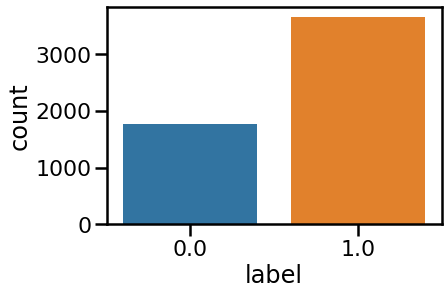

In [139]:
sns.countplot(df.label);

In [140]:
len(df[df.label == 0])

1767

In [141]:
len(df[df.label == 1])

3658

**Random Undersampling**  
Random undersampling randomly deletes records from the majority class. We consider trying this technique because we have a lot of data. But we risk losing some important information for the machine learning algorithm to use while training and predicting.

**Resampling only on the training dataset!**

In [142]:
X = df.iloc[:, 3:]
y = df.label

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)

In [144]:
# Returning X_train and y_train to one dataframe
training_set = pd.concat([X_train, y_train], axis=1)
# How many failed extubation are in the training_set?
len(training_set[training_set.label == 0])

1287

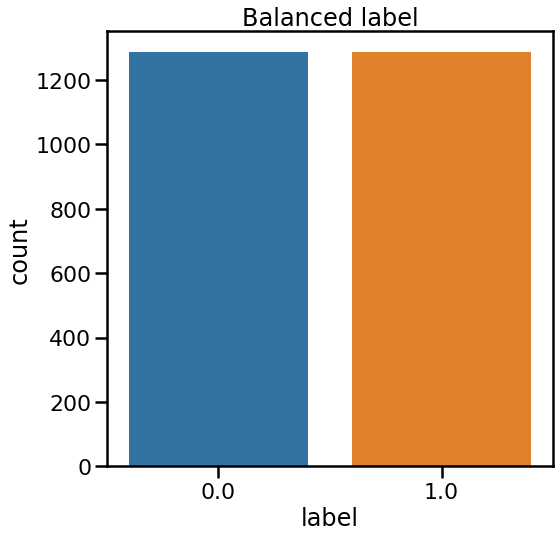

In [145]:
# Shuffle the Dataset.
shuffled_df = training_set.sample(frac=1,random_state=4)

# Put all the failed extubations  in a separate dataset.
failed_df = shuffled_df.loc[shuffled_df['label'] == 0]

#Randomly select 1287 observations from the succeeded
succeeded_df = shuffled_df.loc[shuffled_df['label'] == 1].sample(n=1287, random_state=rs)

# Concatenate both dataframes again
balanced_df = pd.concat([failed_df, succeeded_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('label', data=balanced_df)
plt.title('Balanced label')
plt.show()

## Modeling with the balanced_df 


**Here the process of modeling with the balanced training set is run through.**  
We use the optimized hyperparameters of the previous run.

### Scaling and Train/Test-Split

In [146]:
X = balanced_df.iloc[:, :-1]
y = balanced_df.label

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1930 samples.
Testing set has 644 samples.


In [148]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [149]:
lr_balanced = LogisticRegression(C = 0.1, penalty = 'l2',random_state=rs)
lr_balanced.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42)

In [150]:
y_pred_lr_balanced = lr_balanced.predict(X_test)
print(classification_report(y_test, y_pred_lr_balanced))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr_balanced, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.68      0.61      0.64       322
         1.0       0.64      0.71      0.68       322

    accuracy                           0.66       644
   macro avg       0.66      0.66      0.66       644
weighted avg       0.66      0.66      0.66       644

F-Beta-Score(0.5) =  0.66


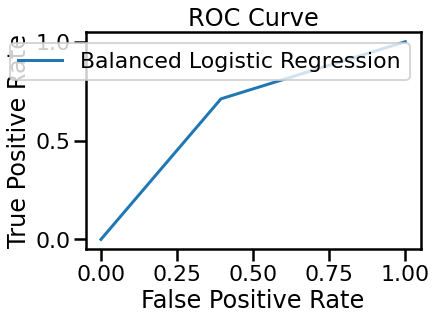

AUC(BalancedlogReg)= 0.70


In [151]:
# Plot the ROC curve
fpr_lr_balanced, tpr_lr_balanced, thresholds_lr_balanced = roc_curve(y_test, y_pred_lr_balanced)
plt.plot(fpr_lr_balanced, tpr_lr_balanced, linestyle='-', label='Balanced Logistic Regression') 
#plt.plot(fpr_lr_best, tpr_lr_best, linestyle=':', label='Best Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_balanced_prob = lr_balanced.predict_proba(X_test)
print(f"AUC(BalancedlogReg)= {roc_auc_score(y_test, y_pred_lr_balanced_prob[:,1]):.2f}")
#print(f"AUC(BestlogReg)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}");

In [152]:
models['LogReg_balanced'] = [precision_score(y_test, y_pred_lr_balanced),
                    fbeta_score(y_test, y_pred_lr_balanced, beta=0.5),
                    roc_auc_score(y_test, y_pred_lr_balanced_prob[:,1]),
                    accuracy_score(y_test, y_pred_lr_balanced)]

### Random Forest

In [153]:
rf_balanced = RandomForestClassifier( bootstrap= False, max_depth= 40, max_features= 'auto', min_samples_leaf= 2,
                                     min_samples_split= 7, n_estimators= 500, random_state=rs)
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_leaf=2,
                       min_samples_split=7, n_estimators=500, random_state=42)

In [154]:
y_pred_rf_balanced = rf_balanced.predict(X_test)

In [155]:
print(classification_report(y_test, y_pred_rf_balanced))
print(confusion_matrix(y_test, y_pred_rf_balanced))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_balanced, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.69      0.65      0.67       322
         1.0       0.67      0.70      0.69       322

    accuracy                           0.68       644
   macro avg       0.68      0.68      0.68       644
weighted avg       0.68      0.68      0.68       644

[[209 113]
 [ 95 227]]
F-Beta-Score(0.5) =  0.67


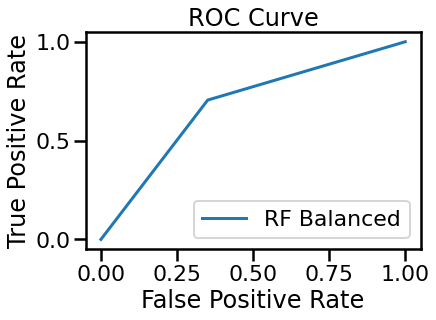

AUC(Rf Balanced)= 0.71


In [156]:
# ROC Curve Base Model and Dummy
fpr_rf_balanced, tpr_rf_balanced, thresholds_rf_balanced = roc_curve(y_test, y_pred_rf_balanced)
#plt.plot(fpr_rf_gs, tpr_rf_gs, linestyle='-', label='RF Best Model')
plt.plot(fpr_rf_balanced, tpr_rf_balanced, linestyle='-', label='RF Balanced')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_balanced = rf_balanced.predict_proba(X_test)
print(f"AUC(Rf Balanced)= {roc_auc_score(y_test, y_proba_rf_balanced[:,1]):.2f}")

In [157]:
models['RF_balanced'] = [precision_score(y_test, y_pred_rf_balanced),
                    fbeta_score(y_test, y_pred_rf_balanced, beta=0.5),
                    roc_auc_score(y_test, y_proba_rf_balanced[:,1]),
                    accuracy_score(y_test, y_pred_rf_balanced)]

### AdaBoost

In [158]:
ada_balanced = AdaBoostClassifier()
ada_balanced.fit(X_train, y_train)
y_pred_ada_balanced = ada_balanced.predict(X_test)
print(classification_report(y_test, y_pred_ada_balanced))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_ada_balanced, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64       322
         1.0       0.64      0.64      0.64       322

    accuracy                           0.64       644
   macro avg       0.64      0.64      0.64       644
weighted avg       0.64      0.64      0.64       644

F-Beta-Score(0.5) =  0.64


Text(0.5, 1.0, 'Confusion matrix')

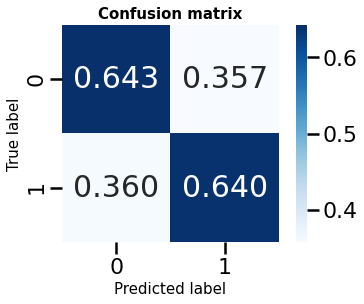

In [159]:
cm = confusion_matrix(y_test, ada_balanced.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

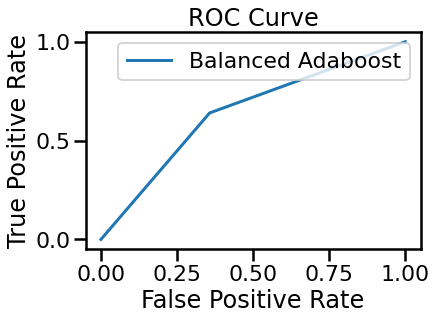

AUC(Adaboost)= 0.69


In [160]:
# Plot the ROC curve
fpr_ada_balanced, tpr_ada_balanced, thresholds_ada_balanced = roc_curve(y_test, y_pred_ada_balanced)
#plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.plot(fpr_ada_balanced, tpr_ada_balanced, linestyle='-', label='Balanced Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob_balanced = ada_balanced.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob_balanced[:,1]):.2f}")

In [161]:
models['Ada_balanced'] = [precision_score(y_test, y_pred_ada_balanced),
                    fbeta_score(y_test, y_pred_ada_balanced, beta=0.5),
                    roc_auc_score(y_test, y_pred_ada_prob_balanced[:,1]),
                    accuracy_score(y_test, y_pred_ada_balanced)]

### XGBoost

In [162]:
# instanciate classifier, fit model
xgboost_balanced = XGBClassifier(random_state=rs)
xgboost_balanced.fit(X_train, y_train)

XGBClassifier(random_state=42)

In [163]:
y_pred_xgb_balanced = xgboost_balanced.predict(X_test)

In [164]:
print(classification_report(y_test, y_pred_xgb_balanced))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_xgb_balanced, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.70      0.61      0.65       322
         1.0       0.65      0.74      0.69       322

    accuracy                           0.67       644
   macro avg       0.68      0.67      0.67       644
weighted avg       0.68      0.67      0.67       644

F-Beta-Score(0.5) =  0.67


Text(0.5, 1.0, 'Confusion matrix')

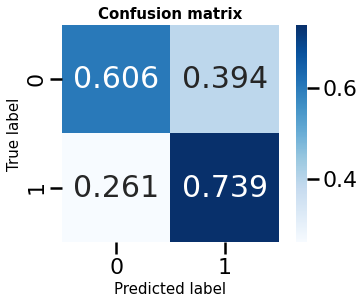

In [165]:
cm = confusion_matrix(y_test, xgboost_balanced.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

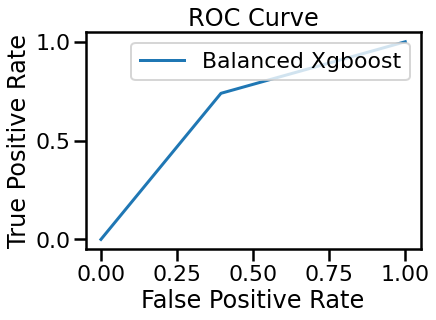

AUC(Xgboost)= 0.72


In [166]:
# Plot the ROC curve
fpr_xgb_balanced, tpr_xgb_balanced, thresholds_xgb_balanced = roc_curve(y_test, y_pred_xgb_balanced)
#plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.plot(fpr_xgb_balanced, tpr_xgb_balanced, linestyle='-', label='Balanced Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob_balanced = xgboost_balanced.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob_balanced[:,1]):.2f}")

In [167]:
models['XGB_balanced'] = [precision_score(y_test, y_pred_xgb_balanced),
                    fbeta_score(y_test, y_pred_xgb_balanced, beta=0.5),
                    roc_auc_score(y_test, y_pred_xgb_prob_balanced[:,1]),
                    accuracy_score(y_test, y_pred_xgb_balanced)]

### SVM Classifier

In [168]:
svc_balanced = SVC(C=100, kernel='rbf', gamma= 0.001, probability=True, random_state=rs)
svc_balanced.fit(X_train, y_train)
y_pred_svc_balanced = svc_balanced.predict(X_test)

In [169]:
print(classification_report(y_test, y_pred_svc_balanced))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc_balanced, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.71      0.65      0.68       322
         1.0       0.68      0.73      0.70       322

    accuracy                           0.69       644
   macro avg       0.69      0.69      0.69       644
weighted avg       0.69      0.69      0.69       644

F-Beta-Score(0.5) =  0.69


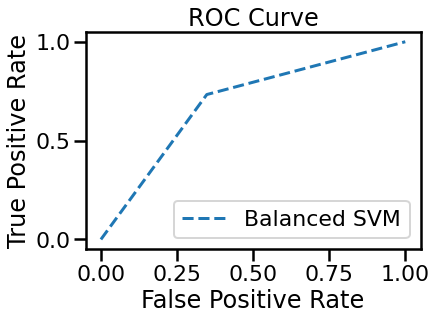

AUC (SVC)= 0.72


In [170]:
# Plot the ROC curve
fpr_svc_balanced, tpr_svc_balanced, thresholds_svc_balanced = roc_curve(y_test, y_pred_svc_balanced)
plt.plot(fpr_svc_balanced, tpr_svc_balanced, linestyle='--', label='Balanced SVM')
#plt.plot(fpr_svc, tpr_svc, linestyle='-', label='SVM Classifier') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_svc_prob_balanced = svc_balanced.predict_proba(X_test)
print(f"AUC (SVC)= {roc_auc_score(y_test, y_pred_svc_prob_balanced[:,1]):.2f}")

In [171]:
models['SVC_balanced'] = [precision_score(y_test, y_pred_svc_balanced),
                    fbeta_score(y_test, y_pred_svc_balanced, beta=0.5),
                    roc_auc_score(y_test, y_pred_svc_prob_balanced[:,1]),
                    accuracy_score(y_test, y_pred_svc_balanced)]

### kNN

In [172]:
knn_balanced = KNeighborsClassifier(n_neighbors=14, leaf_size=1, metric='euclidean', weights= 'uniform')
knn_balanced.fit(X_train, y_train)
y_pred_knn_balanced= knn_balanced.predict(X_test)

In [173]:
print(classification_report(y_test, y_pred_knn_balanced))
print(confusion_matrix(y_test, y_pred_knn_balanced))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_knn_balanced, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62       322
         1.0       0.62      0.67      0.64       322

    accuracy                           0.63       644
   macro avg       0.63      0.63      0.63       644
weighted avg       0.63      0.63      0.63       644

[[192 130]
 [107 215]]
F-Beta-Score(0.5) =  0.63


In [174]:
y_pred_knn_prob_balanced = knn_balanced.predict_proba(X_test)

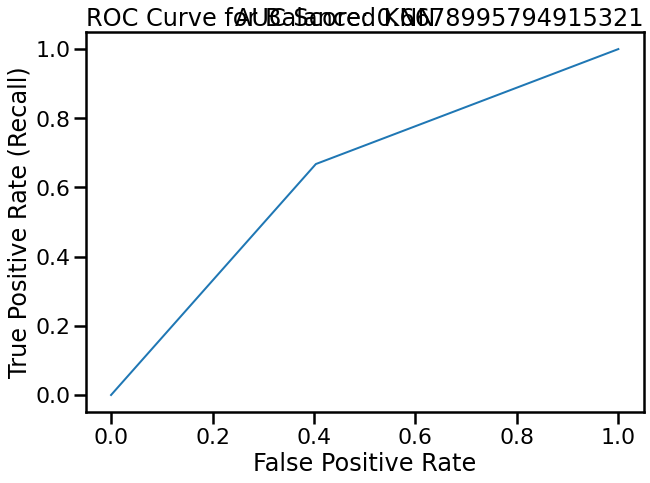

In [175]:
fpr_knn_balanced, tpr_knn_balanced, thresholds_knn_balanced = roc_curve(y_test, y_pred_knn_balanced)
auc_score = roc_auc_score(y_test, y_pred_knn_prob_balanced[:,1])

plt.figure(figsize=(10,7))
plt.plot(fpr_knn_balanced, tpr_knn_balanced, linewidth=2) 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Balanced KNN', loc='left')
plt.title(f'AUC Score: {auc_score}', loc='right');

In [176]:
models['knn_balanced'] = [precision_score(y_test, y_pred_knn_balanced),
                    fbeta_score(y_test, y_pred_knn_balanced, beta=0.5),
                    roc_auc_score(y_test, y_pred_knn_prob_balanced[:,1]),
                    accuracy_score(y_test, y_pred_knn_balanced)]

### Naive Bayes

In [177]:
gnb_balanced = GaussianNB(var_smoothing = 1.5459277364194774)
y_pred_gnb_balanced = gnb_balanced.fit(X_train, y_train).predict(X_test)

In [178]:
print(classification_report(y_test, y_pred_gnb_balanced))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb_balanced, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.51      0.99      0.67       322
         1.0       0.75      0.04      0.07       322

    accuracy                           0.51       644
   macro avg       0.63      0.51      0.37       644
weighted avg       0.63      0.51      0.37       644

F-Beta-Score(0.5) =  0.16


Confusion matrix, without normalization
[[318   4]
 [310  12]]


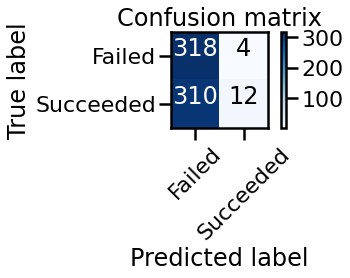

In [179]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb_balanced)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

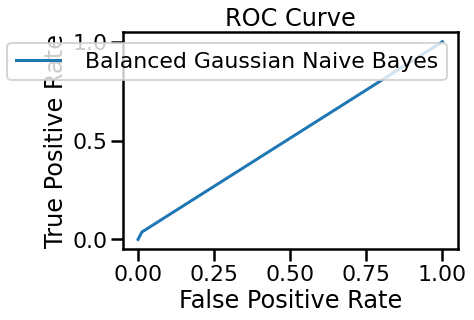

AUC(GNB)= 0.69


In [180]:
# Plot the ROC curve
fpr_gnb_balanced, tpr_gnb_balanced, thresholds_gnb_balanced = roc_curve(y_test, y_pred_gnb_balanced)
#plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Gaussian Naive Bayes') 
plt.plot(fpr_gnb_balanced, tpr_gnb_balanced, linestyle='-', label=' Balanced Gaussian Naive Bayes') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_prob_balanced = gnb_balanced.predict_proba(X_test)
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob_balanced[:,1]):.2f}")

In [181]:
models['GNB_balanced'] = [precision_score(y_test, y_pred_gnb_balanced),
                    fbeta_score(y_test, y_pred_gnb_balanced, beta=0.5),
                    roc_auc_score(y_test, y_pred_gnb_prob_balanced[:,1]),
                    accuracy_score(y_test, y_pred_gnb_balanced)]

### Overview

In [195]:
overview_balanced = pd.DataFrame.from_dict(models, orient='index')
overview_balanced=overview_balanced.round(3)
overview_balanced.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
overview_balanced.sort_values(by=['F-Beta(0.5)', 'Precision', 'Roc-Auc-Score'], ascending=False)

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
XGB_simple,0.751,0.783,0.737,0.752
Ada_simple,0.752,0.780,0.720,0.741
Ada_best,0.747,0.778,0.698,0.742
RF_simple,0.744,0.777,0.709,0.745
XGB_best,0.744,0.777,0.709,0.744
RF_best,0.740,0.775,0.717,0.744
SVC_grid,0.743,0.773,0.700,0.732
SVC_simple,0.732,0.767,0.708,0.732
logReg_best,0.733,0.766,0.711,0.726
logReg_simple,0.733,0.765,0.708,0.724


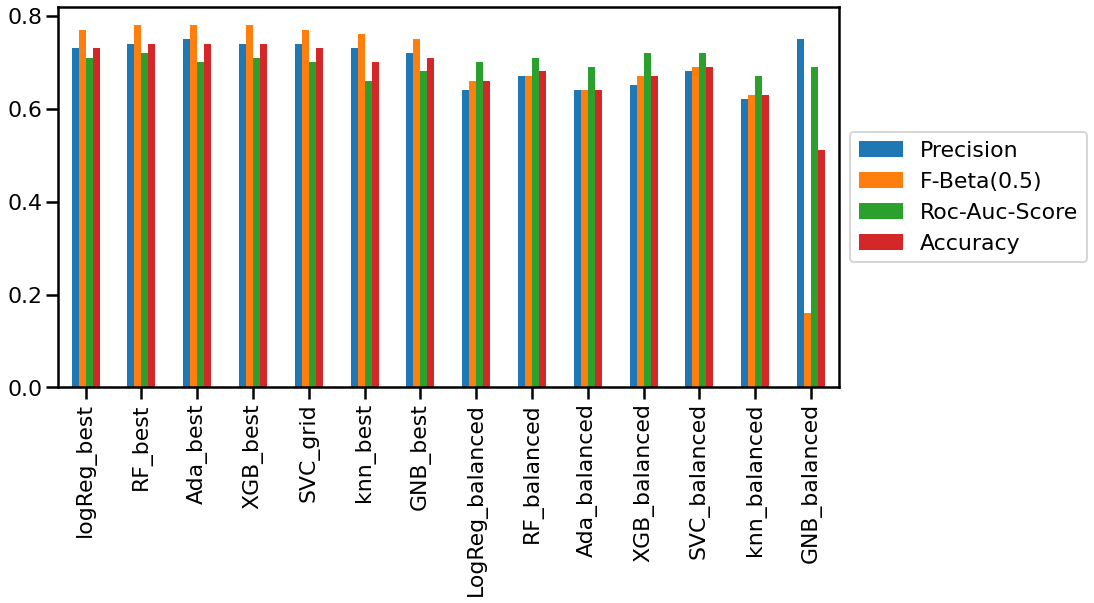

In [183]:
bestmodels_balanced = overview_balanced.drop(['logReg_simple', 'RF_simple', 'Ada_simple', 'XGB_simple',
                            'SVC_simple', 'knn_simple', 'GNB_simple'],axis=0)
bestmodels_balanced.plot(kind='bar', figsize=(14,7))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

### Conclusion

The performance of every model has decreased after undersampling.    
It seems that undersampling has decreased the amount of available information for the model.

# Summary

In [196]:
summary = {}
summary['Dummy']= [0.663286, 0.662883, 0.486239, 0.546567, 'Dummy', 24, '-']
summary['Best_Base']= [0.729621, 0.760303, 0.699078, 0.714480,'XGBoost', 24, 'tracheo, FiO2, PEEP' ]
summary['Best_Advanced']= [0.750649, 0.783198, 0.736580, 0.752395, 'XGBoost', 77, 'tracheo, hours_mechvent, median_SaO2' ]
summary['Best_Reduced']= [0.752389, 0.784562, 0.729612, 0.753869, 'XGBoost', 12, 'tracheo, hours_mechvent, median_SaO2']
summary['Best_Balanced']= [0.678, 0.688, 0.724, 0.693, 'SVC', 77, '-']

In [197]:
summ = pd.DataFrame.from_dict(summary, orient='index')
summ=summ.round(3)
summ.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy", 
                'Classifier', 'Number_of_Features', 'Top_3_Features']
summ.sort_values(by='F-Beta(0.5)', ascending = False)

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy,Classifier,Number_of_Features,Top_3_Features
Best_Reduced,0.752,0.785,0.730,0.754,XGBoost,12,"tracheo, hours_mechvent, median_SaO2"
Best_Advanced,0.751,0.783,0.737,0.752,XGBoost,77,"tracheo, hours_mechvent, median_SaO2"
Best_Base,0.730,0.760,0.699,0.714,XGBoost,24,"tracheo, FiO2, PEEP"
Best_Balanced,0.678,0.688,0.724,0.693,SVC,77,-
Dummy,0.663,0.663,0.486,0.547,Dummy,24,-


**The meaning of the 12 identified features of the best XGBoost Model:**   
+ **tracheo**: wether the patient is tracheotomized 
+ **hours_mechvent**: duration (in hours) of the mechanical ventilation since ICU admission  
+ **median_SaO<sub>2</sub> / min_SaO<sub>2</sub>**: Median / Minimum of the oxygen saturation within last 48 hours before extubation  
+ **median_PaO<sub>2</sub> / minimum_PaO<sub>2</sub>**: Median / Minimum of the PaO<sub>2</sub> course within 48 hours before extubation. PaO<sub>2</sub> is defined as the partial pressure of oxygen in arterial blood.
+ **resp_rat**: Respiratory rate, the frequency at which a person inhales and exhales.
+ **pf_ratio**: The ratio of arterial partial pressure of oxygen to inspired fractional concentration of oxygen; used to measure oxygen transfer. Is also named respiratory instability.
+ **max_FiO<sub>2</sub>**: Maximum of the fraction of inspired oxygen within last 48 hours before extubation   
+ **age**: absolute age at the time of extubation

Source: [medical-dictionary](https://medical-dictionary.thefreedictionary.com/)


A precision of 0.752 means that in our best model, 75% of positive identification are actually correct.
Since the data set is not severely inbalance, the accuracy score can also be used to evaluate the model. Interpreting an accuracy of 0.75 tell us that more than 75% of all predictions are correct.   
Due to their clinical use case, decision support systems need to be accurate and robust; however, they also should be interpretable and capable of integrating clinical  knowledge into the analysis. Until know, we haven't focused on interpretability. We mainly focused on the evaluation metric F-Beta(0.5), to ensure als little false positives as possible. Feature importance is the first attempt to tackle interpretability. If there would be a higher demand on interpretability, we would rather prefer transparent classifiers, such as Decision Tree, Logistic Regression or linear SVM.
